In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Definitions

- p: freq of η
- q: freq of H
- x: freq of A within η
- 1-x: freq of B within η
- y: freq of A within H
- 1-y: freq of B within H

## Recursion 

$$
x' = \frac{x \omega_A ((1-\eta) x + \eta) + (1-x) \omega_B (1-\eta) x}{\bar{\omega}_{\eta}} \\
y' = \frac{y \omega_A ((1-H) y + H) + (1-y) \omega_B (1-H) y}{\bar{\omega_H}} \\ 
p' = p \frac{x \omega_A + (1-x) \omega_B}{\bar{\omega}} \\
q' = 1-p' = q \frac{y \omega_A + (1-y) \omega_B}{\bar{\omega}} \\
\bar{\omega} = p \bar{\omega_{\eta}}  + q \bar{\omega_{H}} \\
\bar{\omega_{\eta}} = x \omega_A + (1-x) \omega_B \\
\bar{\omega_{H}} = y \omega_A + (1-y) \omega_B
$$

# Modifier numerical simulation

In [2]:
def recursion(p, x, y, W, w, e):
    if np.random.rand() > e:
        W, w = w, W
   
    xx = (x * W * ((1 - η) * x + η) + 
        (1 - x) * w * (1 - η) * x) / (x * W + (1 - x) * w) 
    yy = (y * W * ((1 - H) * y + H) + 
        (1 - y) * w * (1 - H) * y) / (y * W + (1 - y) * w)

    q = 1 - p

    pp = p * (x * W + (1 - x) * w)
    meanW = pp + q * (y * W +  (1 - y) * w)
    pp /= meanW

    return pp, xx, yy

In [10]:
η = 0.1
H = 0.01
W = 1
w = 0.1

n = 1000000
p = np.array([0.999]*n)
x = np.array([0.1]*n)
y = np.array([0.1]*n)
rate = np.array([0.0]*n)
rate[0] = p[0] * η + (1 - p[0]) * H
e = 0
invasions = []

for t in range(1, n):
    W, w = w, W
    p[t], x[t], y[t] = recursion(
        p[t-1], x[t-1], y[t-1], W, w, e
    )
    rate[t] = p[t] * η + (1-p[t]) * H
    if p[t] > 0.999:
        p[t] = 0.999 # mutator locus mutation
    if p[t] < 0.001:
        p[t] = 1-p[t]
        η, H = H, H/10
        x[t] = y[t]
        invasions.append(t)
        
q = 1 - p

(1e-05,
 1.0000000000000002e-06,
 0.99563375729252868,
 [673, 5237, 51068, 509600])

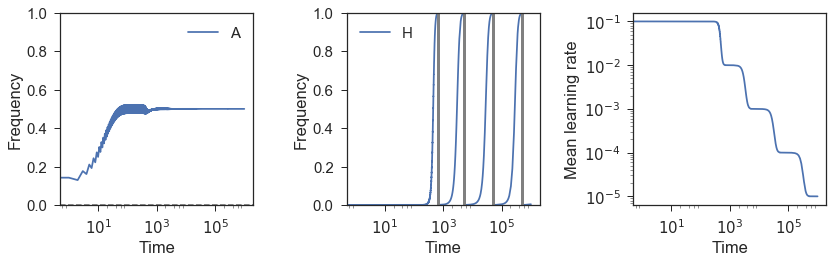

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=False, sharex=True)
axes[1].plot(q, label='H')
axes[0].plot(p*x + q*y, label='A')
axes[0].axhline(e, ls='--', color='gray')
axes[2].plot(rate)
for inv in invasions:
    axes[1].axvline(inv, ls='-', lw=3, color='gray')
for i in range(2):
    axes[i].set(ylim=(0,1), ylabel='Frequency', xlabel='Time', xscale='log')
    axes[i].legend()
axes[2].set(ylabel='Mean learning rate', xlabel='Time', yscale='log')
fig.tight_layout()
η, H, p[-1], invasions

# Mean fitness

In [104]:
s_ = np.linspace(0, 1, 100).reshape(100, 1)
n_ = np.linspace(0, 1, 100)

ww = (s_ * (1 - n_) -2 + np.sqrt((1 - n_)**2 * s_**2 +4*(1 + s_)))/(2*(2 - n_))

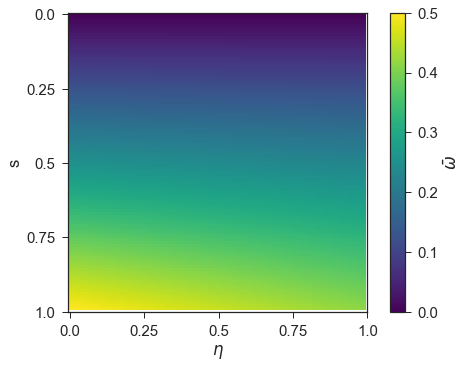

In [105]:
fig, ax = plt.subplots()

im = ax.imshow(ww, cmap='viridis')
cb = plt.colorbar(im, label=r'$\bar{\omega}$')
ax.set_ylabel('s')
ax.set_xlabel(r'$\eta$')

ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5));

# Modifier analysis

In [12]:
import sympy
sympy.init_printing()

In [13]:
x, s, η, H, ε = sympy.symbols('x s η H ε', real=True, positive=True)

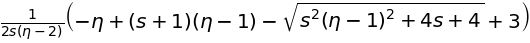

In [35]:
x_star = ((1 + s) * (1 - η) - (3 - η) + sympy.sqrt((1 - η)**2 * s**2 + 4 * (1 + s))) / (2 * (2 -  η) * s)
x_star = sympy.simplify(x_star)
x_star

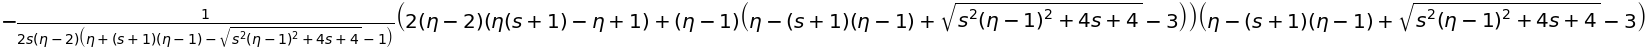

In [36]:
x_star_prime = x_star * (x_star * (1 - η) * s + η * (1 + s) + (1 - η)) / (1 + s * x_star)
x_star_prime = sympy.simplify(x_star_prime)
x_star_prime

In [37]:
x_star_eta_0 = 1/(4*s) * (s + (s+2) -2)
x_star_eta_0

In [16]:
x_star, x_star_prime = x_star_eta_0, x_star_eta_0

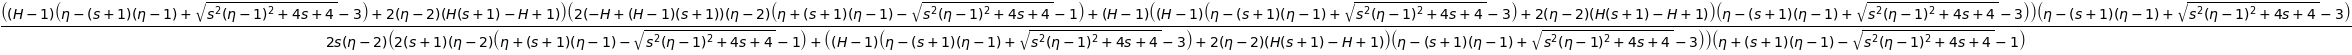

In [38]:
y_prime = x_star * (x_star * (1 - H) * s + H * (1 + s) + (1 - H)) / (1 + s * x_star)
y_prime_prime = y_prime * (y_prime * (1 - H) * (-s) + H + (1 - H) * (1 + s)) / (1 + s - s * y_prime)
y_prime_prime = sympy.simplify(y_prime_prime)
y_prime_prime

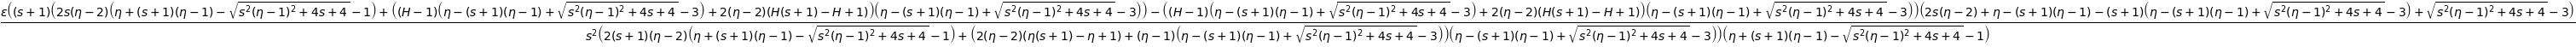

In [39]:
q_prime = ε * (x_star * (1 + s) + (1 - x_star) ) / (1 + s * x_star)
q_prime_prime = q_prime * (y_prime + (1 - y_prime) * (1 + s)) / (1 + s - x_star_prime * s)
q_prime_prime = sympy.simplify(q_prime_prime)
q_prime_prime

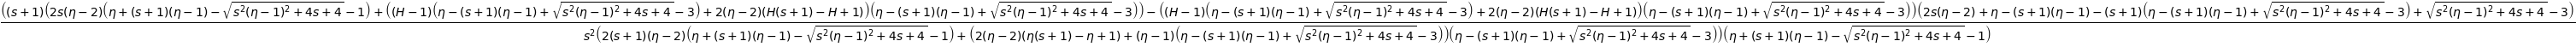

In [40]:
a = q_prime / ε * q_prime_prime / q_prime
sympy.simplify(a)

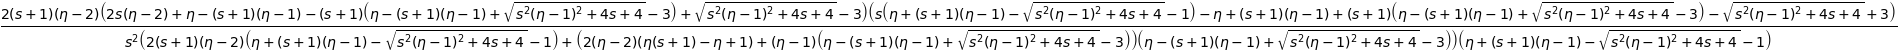

In [43]:
sympy.simplify(a.subs({H:1}))

So when $\eta=0$, $\lambda = \frac{q''}{\epsilon} = 1 - H\Big(\frac{s}{s+2}\Big)^2 < 1$ and $\eta=0$ is Evolutionary stable.

**What about when $0 < \eta < 1$ and $H=1$?**

In [41]:
a_ = np.array(
    [
        [
            float(a.subs({η: 1, H: H_, s: s_})) 
            for s_ in np.linspace(0, 1, 100)
        ] 
        for H_ in np.linspace(0, 1 , 100)
    ]
)

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater_equal
/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less_equal


(nan, nan, False, False)

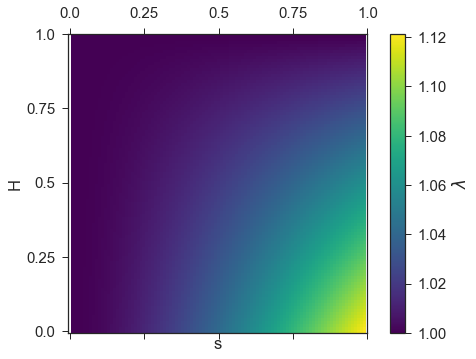

In [42]:
fig, ax = plt.subplots()
im = ax.matshow(a_, cmap='viridis', origin=(0,0))
ax.set_xlabel('s')
ax.set_ylabel('H')
cb = plt.colorbar(im, label='$\lambda$')
ax.set_xticks(np.linspace(0, 100, 5))
ax.set_xticklabels(np.linspace(0, 1, 5))
ax.set_yticks(np.linspace(0, 100, 5))
ax.set_yticklabels(np.linspace(0, 1, 5))

a_.min(), a_.max(), (a_>=1).all(), (a_<=1).all()

In [24]:
a.subs({H: 0.1, s: 0}), a.subs({H: 0, s: 0.1}), a.subs({H: 0.1, s: 1})